<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [62]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import numpy.ma as ma

import biom
import arviz as az
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr

from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
berding_directory = '../sfari/data/sra/Berding2020'

results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

pd.options.display.max_rows = 100 

Load age-sex matched information

In [63]:
# load biom tables
agesex_biom = biom.load_table(f'{kang_directory}/age_sex_match_week0_ogu.biom')
agesex_table = agesex_biom.to_dataframe().T

# load metadata tables
agesex_md = pd.read_table(f'{kang_directory}/combined_sample_metadata_0.txt', index_col=0)

# load taxonomy
taxonomy = pd.read_table('~/databases/wol/taxonomy/ranks.tsv', index_col=0)
taxid = pd.read_table('~/databases/wol/taxonomy/taxid.map', header=None, dtype=str)
taxid.columns = ['GOTU', 'genome']
mapping = pd.merge(taxid, taxonomy, left_on='GOTU', right_index=True)
mapping = mapping.set_index('genome')

# load differentials
posterior_name = 'age_sex_matched_posterior'
agesex_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
agesex_diffs = extract_differentials(agesex_fname)

# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
agesex_stats = ranking(agesex_diffs, reference_percentile=50, log_probs=True)

# make age-sex differences comparable
agesex_diffs = pd.merge(agesex_diffs, mapping[['GOTU']], 
                        left_index=True, right_index=True).groupby('GOTU').sum()
sort_col = 'mean'

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


Load sibling matched datasets

In [64]:
posterior_name = '../sfari/data/sra/Son2015/sibling_matched_posterior/differentials.nc'
son_diffs = extract_differentials(posterior_name)

posterior_name = '../sfari/data/sra/David2021/sibling_matched_posterior/differentials.nc'
david_diffs = extract_differentials(posterior_name)

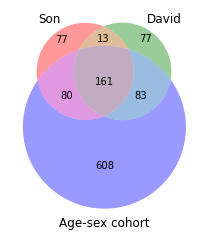

In [65]:
# Venn diagram to visualize overlap
venn3([set(son_diffs.index), 
       set(david_diffs.index),
       set(agesex_diffs.index)], 
      set_labels=['Son', 'David', 'Age-sex cohort'])

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.1354641676421091, 0.035576650146661865)

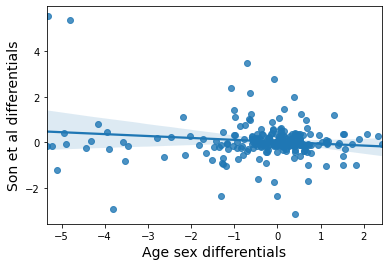

In [66]:
common_taxa = list(set(son_diffs.index) & set(agesex_diffs.index))

sns.regplot(son_diffs.mean(axis=1).loc[common_taxa],
            agesex_diffs.mean(axis=1).loc[common_taxa])
plt.xlabel('Age sex differentials', fontsize=14)
plt.ylabel('Son et al differentials', fontsize=14)
pearsonr(son_diffs.mean(axis=1).loc[common_taxa],
         agesex_diffs.mean(axis=1).loc[common_taxa])

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.1887291905222511, 0.003080908039233475)

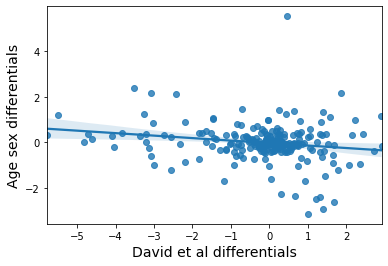

In [67]:
common_taxa = list(set(david_diffs.index) & set(agesex_diffs.index))

sns.regplot(david_diffs.mean(axis=1).loc[common_taxa],
            agesex_diffs.mean(axis=1).loc[common_taxa])

plt.ylabel('Age sex differentials', fontsize=14)
plt.xlabel('David et al differentials', fontsize=14)

pearsonr(agesex_diffs.mean(axis=1).loc[common_taxa],
         david_diffs.mean(axis=1).loc[common_taxa])

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


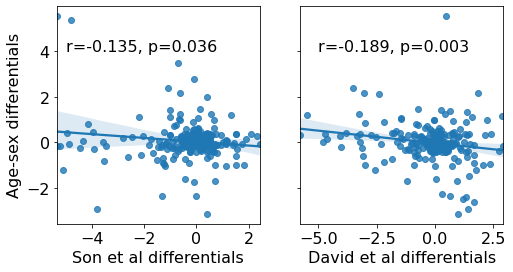

In [89]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))

common_taxa = list(set(son_diffs.index) & set(agesex_diffs.index))
sns.regplot(son_diffs.mean(axis=1).loc[common_taxa],
            agesex_diffs.mean(axis=1).loc[common_taxa], ax=ax[0])
r, p = pearsonr(agesex_diffs.mean(axis=1).loc[common_taxa],
                son_diffs.mean(axis=1).loc[common_taxa])
ax[0].annotate(xy=(-5, 4), text=f'r={np.round(r, 3)}, p={np.round(p, 3)}', fontsize=16)

common_taxa = list(set(david_diffs.index) & set(agesex_diffs.index))
sns.regplot(david_diffs.mean(axis=1).loc[common_taxa],
            agesex_diffs.mean(axis=1).loc[common_taxa], ax=ax[1])
r, p = pearsonr(agesex_diffs.mean(axis=1).loc[common_taxa],
                david_diffs.mean(axis=1).loc[common_taxa])
ax[1].annotate(xy=(-5, 4), text=f'r={np.round(r, 3)}, p={np.round(p, 3)}', fontsize=16)
ax[0].set_ylabel('Age-sex differentials', fontsize=16)
ax[0].set_xlabel('Son et al differentials', fontsize=16)
ax[1].set_xlabel('David et al differentials', fontsize=16)
ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)
ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.09007669761264893, 0.23719238257534686)

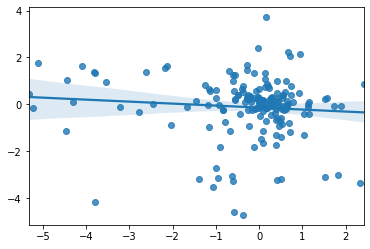

In [58]:
common_taxa = list(set(son_diffs.index) & set(david_diffs.index))

sns.regplot(son_diffs.mean(axis=1).loc[common_taxa],
            david_diffs.mean(axis=1).loc[common_taxa])
pearsonr(son_diffs.mean(axis=1).loc[common_taxa],
         david_diffs.mean(axis=1).loc[common_taxa])